In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import random
seed = 0
np.random.seed(seed)
random.seed(seed)
import scipy.sparse as sp
import time
from banksy_utils.filter_utils import filter_cells
from banksy_utils.load_data import load_adata
from banksy_utils.filter_utils import normalize_total, filter_hvg
from banksy.main import median_dist_to_nearest_neighbour
from banksy.initialize_banksy import initialize_banksy
from banksy.main import concatenate_all
from banksy.embed_banksy import generate_banksy_matrix
from banksy_utils.umap_pca import pca_umap
from banksy.cluster_methods import run_Leiden_partition
from banksy.plot_banksy import plot_results
import anndata as ad
import pandas as pd

In [7]:
max_m = 1
nbr_weight_decay = "scaled_gaussian"
lambda_list = [0.8]
pca_dims = [20]
n_neighbors=8
condition_key = "batch"

In [8]:
adata_batch1 = sc.read_h5ad('/home/dbj/SpaLA/STARmap/starmap_plus_mouse_cns_batch1.h5ad')
adata_batch2 = sc.read_h5ad('/home/dbj/SpaLA/STARmap/starmap_plus_mouse_cns_batch2.h5ad')
adata_batch3 = sc.read_h5ad('/home/dbj/SpaLA/STARmap/starmap_plus_mouse_cns_batch3.h5ad')
adata_list=[adata_batch1,adata_batch2,adata_batch3]
adata = ad.concat(adata_list, join="inner")

In [17]:
adata

AnnData object with n_obs × n_vars = 207591 × 1022
    obs: 'Main_molecular_cell_type', 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type', 'batch', 'spatial_x', 'spatial_y'
    obsm: 'spatial', 'banksy'
    layers: 'counts'

In [9]:
data=pd.read_csv('/home/dbj/LPFoundation/STARmapPLUS/cluster.csv',index_col=0)
data=data.loc[adata.obs_names,:]
adata.obs['Main_molecular_tissue_region']=data['Main_molecular_tissue_region']

In [10]:
adata_original=adata

In [11]:
adata_new = sc.AnnData(sp.csr_matrix((adata_original.shape[0], adata_original.shape[1]),dtype=np.float32))
adata_new.var_names = adata_original.var_names
adata_new.obs_names = adata_original.obs_names
adata_new.obsm["spatial"] = adata_original.obsm["spatial"]
adata_new.obs[condition_key] = adata_original.obs[condition_key]

In [12]:
%%time
adata_batch_list = []
for batch in adata_original.obs['batch'].unique():
    adata = adata_original[adata_original.obs['batch'] == batch].copy()
    max_m = 1 # use both mean and AFT
    nbr_weight_decay = "scaled_gaussian" # can also choose "reciprocal", "uniform" or "ranked"
    lambda_list = [0.8]
    pca_dims = [20]
    adata.obs["spatial_x"] = adata.obsm['spatial'][:, 0]
    adata.obs["spatial_y"] = adata.obsm['spatial'][:, 1]
    
    banksy_dict = initialize_banksy(
        adata,
        ("spatial_x", "spatial_y", "spatial"),
        n_neighbors,
        nbr_weight_decay=nbr_weight_decay,
        max_m=max_m,
        plt_edge_hist=False,
        plt_nbr_weights=False,
        plt_agf_angles=False, 
        plt_theta=False)
    banksy_dict, banksy_matrix = generate_banksy_matrix(adata,banksy_dict,lambda_list,max_m)
    pca_umap(banksy_dict,pca_dims = pca_dims,add_umap = True,plt_remaining_var = False)
    adata.obsm['banksy'] = banksy_dict[nbr_weight_decay][lambda_list[0]]["adata"].obsm["reduced_pc_20"]
    adata_batch_list.append(adata)
    
adata_original = ad.concat(adata_batch_list, join="outer")
sc.external.pp.harmony_integrate(adata_original, "batch", basis='banksy')
adata_new.obsm['banksy'] = adata_original.obsm['X_pca_harmony']


Median distance to closest cell = 0.05577615609805576

---- Ran median_dist_to_nearest_neighbour in 0.25 s ----

---- Ran generate_spatial_distance_graph in 0.44 s ----

---- Ran row_normalize in 0.24 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 2.40 s ----

---- Ran generate_spatial_distance_graph in 0.65 s ----

---- Ran theta_from_spatial_graph in 0.54 s ----

---- Ran row_normalize in 0.19 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 3.04 s ----

Runtime Feb-17-2026-09-52

1022 genes to be analysed:
Gene List:
Index(['A2M', 'ABCC9', 'ABI3BP', 'ACBD7', 'ACTA2', 'ADA', 'ADAMTS15', 'ADARB2',
       'ADCY1', 'ADCYAP1',
       ...
       'WHRN', 'WIF1', 'WNT2', 'WNT4', 'YJEFN3', 'ZBTB20', 'ZFHX4', 'ZFP239',
       'ZIC1', 'ZMYM1'],
      dtype='object', name='GENE', length=1022)

Check if X contains only finite (non-NAN) values
Decay Type: scaled_gaussian
Weights Object: {'weights': {0: <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 729968 stored el

2026-02-17 10:01:57,251 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2026-02-17 10:02:17,766 - harmonypy - INFO - sklearn.KMeans initialization complete.
2026-02-17 10:02:19,084 - harmonypy - INFO - Iteration 1 of 10
2026-02-17 10:04:10,843 - harmonypy - INFO - Iteration 2 of 10
2026-02-17 10:06:03,861 - harmonypy - INFO - Iteration 3 of 10
2026-02-17 10:07:55,684 - harmonypy - INFO - Iteration 4 of 10
2026-02-17 10:09:49,296 - harmonypy - INFO - Iteration 5 of 10
2026-02-17 10:11:42,596 - harmonypy - INFO - Iteration 6 of 10
2026-02-17 10:13:36,870 - harmonypy - INFO - Iteration 7 of 10
2026-02-17 10:15:03,559 - harmonypy - INFO - Iteration 8 of 10
2026-02-17 10:16:55,888 - harmonypy - INFO - Iteration 9 of 10
2026-02-17 10:18:23,174 - harmonypy - INFO - Iteration 10 of 10
2026-02-17 10:20:17,891 - harmonypy - INFO - Converged after 10 iterations


CPU times: user 9h 16min 54s, sys: 10h 51min 3s, total: 20h 7min 58s
Wall time: 28min 16s


In [13]:
%%time
sc.pp.neighbors(adata_new, use_rep='banksy')
sc.tl.umap(adata_new)

CPU times: user 41min 57s, sys: 14min 43s, total: 56min 41s
Wall time: 4min 32s


In [19]:
adata_new.obs['Main_molecular_tissue_region']=data['Main_molecular_tissue_region']

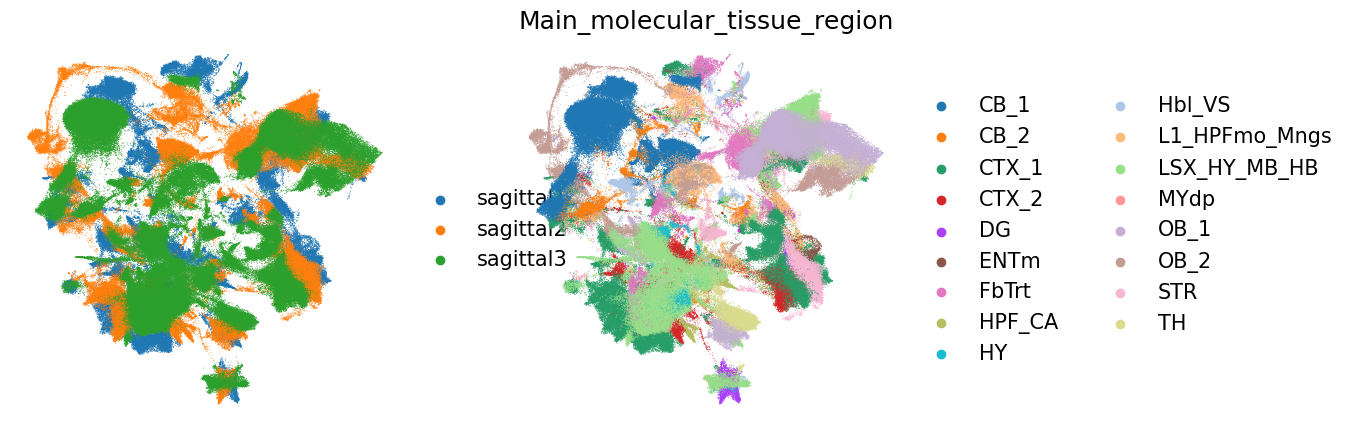

In [20]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['font.size'] = 15
sc.pl.umap(adata=adata_new,color=['batch','Main_molecular_tissue_region'],title='',size=1.5,colorbar_loc=None,frameon=False)

In [21]:
adata_new.write_h5ad('/home/dbj/SpaLP/gittest/repoduced/result/Fig4BANKSYSTARmapPLUS.h5ad',compression='gzip')